In [ ]:
#This run seems to have trained on the CPU

In [1]:
import sklearn
import matplotlib
import h5py
import numpy as np
import scipy
import seaborn
import math

In [2]:
import tensorflow as tf

2023-11-04 13:21:23.753239: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12


In [3]:
print(tf.__version__)

1.15.5


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


2023-11-04 13:21:28.772415: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcuda.so.1
2023-11-04 13:21:53.462259: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1674] Found device 0 with properties: 
name: NVIDIA A100 80GB PCIe major: 8 minor: 0 memoryClockRate(GHz): 1.41
pciBusID: 0000:01:00.0
2023-11-04 13:21:53.464011: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1674] Found device 1 with properties: 
name: NVIDIA A100 80GB PCIe major: 8 minor: 0 memoryClockRate(GHz): 1.41
pciBusID: 0000:25:00.0
2023-11-04 13:21:53.465724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1674] Found device 2 with properties: 
name: NVIDIA A100 80GB PCIe major: 8 minor: 0 memoryClockRate(GHz): 1.41
pciBusID: 0000:c1:00.0
2023-11-04 13:21:53.467433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1674] Found device 3 with properties: 
name: NVIDIA A100 80GB PCIe major: 8 minor: 0 memoryClockRate(GHz): 1.41
pciBusID: 0000:e1:00.0
202

In [5]:
#from tensorflow.python.keras.layers import Input, LSTM, RepeatVector, Dense
import tensorflow.keras as keras

In [6]:
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [7]:
#Prepare Training Data:
path_to_X = "./Normalised/X.npy"
path_to_Y = "./Normalised/Y.npy"

X = np.load(path_to_X)
Y = np.load(path_to_Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
print(len(X_train))
print(len(X_test))

49730
12433


In [8]:
# Reshape the input and output data for the encoder and decoder
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # (No of Data, 50) to (No of data, 50,1)
print("X-train shape: ", X_train_reshaped.shape)
Y_train_reshaped = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
print("Y-train shape: ", Y_train_reshaped.shape)
# Define the input shape for the encoder
input_shape = X_train_reshaped.shape[1:]  # Shape: (sequence_length, 1) # 50,1
print("Input_shape: ", input_shape)

X-train shape:  (49730, 50, 1)
Y-train shape:  (49730, 81, 1)
Input_shape:  (50, 1)


In [9]:
#Compile the Model:
# Assuming you have X_train and Y_train as the input and output data

# Define the encoder
encoder_inputs = Input(shape=input_shape)
encoder_lstm = LSTM(40)(encoder_inputs)
encoder_model = Model(encoder_inputs, encoder_lstm)

# Define the input shape for the decoder (with 40 units to match encoder LSTM units)
decoder_inputs = Input(shape=(40,))  # This will serve as the initial state of the decoder LSTM
decoder_lstm = LSTM(40, return_sequences=True)(RepeatVector(Y_train_reshaped.shape[1])(decoder_inputs))
decoder_outputs = Dense(1, activation='sigmoid')(decoder_lstm)

# Define the decoder model
decoder_model = Model(decoder_inputs, decoder_outputs)

# Create the full autoencoder model
autoencoder_outputs = decoder_model(encoder_lstm)
autoencoder = Model(encoder_inputs, autoencoder_outputs)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae'])

# Display the model summary
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 40)                6720      
_________________________________________________________________
model_1 (Model)              (None, 81, 1)             13001     
Total params: 19,721
Trainable params: 19,721
Non-trainable params: 0
_________________________________________________________________


In [10]:
#Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
mc = ModelCheckpoint("./Saved_Models_Data/best_initial_enc_dec.h5", monitor = 'val_loss',mode='min', save_best_only=True, verbose=1)
history = autoencoder.fit(X_train_reshaped, Y_train_reshaped, batch_size=32, epochs=200, validation_split=0.2, callbacks=[early_stopping, mc])

Train on 39784 samples, validate on 9946 samples


2023-11-04 13:22:33.044285: I tensorflow/core/platform/profile_utils/cpu_utils.cc:109] CPU Frequency: 2600150000 Hz
2023-11-04 13:22:33.052966: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7a148d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-04 13:22:33.053080: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-11-04 13:22:33.553789: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5bdc190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-04 13:22:33.553874: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-11-04 13:22:33.553887: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-11-04 13:22:33.553897: I tensorflow/compiler/xla/service/service.cc:

Epoch 1/200


2023-11-04 13:22:34.940414: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcublas.so.12


39776/39784 [============================>.] - ETA: 0s - loss: 0.1192 - mean_absolute_error: 0.2438
Epoch 00001: val_loss improved from inf to 0.10358, saving model to ./Saved_Models_Data/best_initial_enc_dec.h5
39784/39784 [==============================] - 172s 4ms/sample - loss: 0.1192 - mean_absolute_error: 0.2438 - val_loss: 0.1036 - val_mean_absolute_error: 0.2193
Epoch 2/200
39776/39784 [============================>.] - ETA: 0s - loss: 0.0895 - mean_absolute_error: 0.1883
Epoch 00002: val_loss improved from 0.10358 to 0.07935, saving model to ./Saved_Models_Data/best_initial_enc_dec.h5
39784/39784 [==============================] - 167s 4ms/sample - loss: 0.0895 - mean_absolute_error: 0.1883 - val_loss: 0.0794 - val_mean_absolute_error: 0.1626
Epoch 3/200
39776/39784 [============================>.] - ETA: 0s - loss: 0.0772 - mean_absolute_error: 0.1548
Epoch 00003: val_loss improved from 0.07935 to 0.07785, saving model to ./Saved_Models_Data/best_initial_enc_dec.h5
39784/3978

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 00041: val_loss did not improve from 0.03994
39784/39784 [==============================] - 187s 5ms/sample - loss: 0.1045 - mean_absolute_error: 0.1479 - val_loss: 0.1088 - val_mean_absolute_error: 0.1527
Epoch 42/200
39776/39784 [============================>.] - ETA: 0s - loss: 0.1061 - mean_absolute_error: 0.1504
Epoch 00042: val_loss did not improve from 0.03994
39784/39784 [==============================] - 183s 5ms/sample - loss: 0.1061 - mean_absolute_error: 0.1504 - val_loss: 0.1056 - val_mean_absolute_error: 0.1502
Epoch 43/200
39776/39784 [============================>.] - ETA: 0s - loss: 0.1024 - mean_absolute_error: 0.1466
Epoch 00043: val_loss did not improve from 0.03994
39784/39784 [==============================] - 190s 5ms/sample - loss: 0.1024 - mean_absolute_error: 0.1466 - val_loss: 0.1002 - val_mean_absolute_error: 0.1467
Epoch 44/200
39776/39784 [============================>.] - ETA: 0s - loss: 0.0998 - mean_absolute_error: 0.1458
Epoch 00044: val_loss di

In [13]:
import matplotlib.pyplot as plt

12433/12433 [==============================] - 12s 961us/sample - loss: 0.0856 - mean_absolute_error: 0.1206
Test loss (MSE): 0.08564584417246011
Mean Absolute Error: 0.12064731
Root Mean Squared Error (RMSE): 0.292653112357378


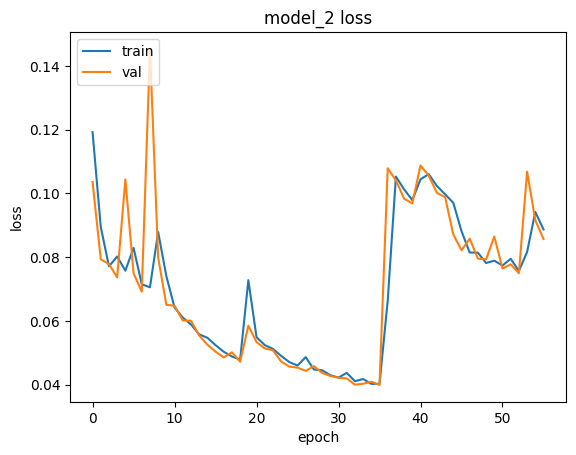

In [14]:
#Evaluate the model that was just trained:
# Reshape the test data for the encoder and decoder
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
Y_test_reshaped = Y_test.reshape(Y_test.shape[0], Y_test.shape[1], 1)

# Evaluate the model on the test data and print the results
evaluation = autoencoder.evaluate(X_test_reshaped, Y_test_reshaped)
print("Test loss (MSE):", evaluation[0])
print("Mean Absolute Error:", evaluation[1])

# Calculate RMSE manually
mse_value = evaluation[0]
rmse_value = np.sqrt(mse_value)
print("Root Mean Squared Error (RMSE):", rmse_value)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(autoencoder.name+' loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
#Evaluate the saved best model:
from tensorflow.keras.models import load_model
saved_model = load_model("./Saved_Models_Data/best_initial_enc_dec.h5")
best_eval = saved_model.evaluate(X_test_reshaped, Y_test_reshaped)

print("Best Test loss (Mean Squared Error):", best_eval[0])
print("Mean Absolute Error:", best_eval[1])
print("len(best_eval: ", len(best_eval))

# Calculate RMSE manually
mse_value = best_eval[0]
rmse_value = np.sqrt(mse_value)
print("Root Mean Squared Error (RMSE):", rmse_value)

12433/12433 [==============================] - 13s 1ms/sample - loss: 0.0403 - mean_absolute_error: 0.0785
Best Test loss (Mean Squared Error): 0.04029229377461349
Mean Absolute Error: 0.07854707
len(best_eval:  2
Root Mean Squared Error (RMSE): 0.20072940435973374


In [17]:
#save the predictions:
predictions = saved_model.predict(X_test_reshaped)
original_shape_predictions = predictions.reshape(X_test.shape[0], Y_test.shape[1])
#save the predictions:
np.save("./Saved_Models_Data/best_initial_enc_pred_orig.npy",original_shape_predictions)

In [18]:
for sample in range(3):
  print(f"SAMPLE: {sample}")
  for i in range (81):
    print(f"Index {i} Ground truth: {Y_test[sample][i]} Predicted: {original_shape_predictions[sample][i]}")

SAMPLE: 0
Index 0 Ground truth: 0 Predicted: 0.03737391531467438
Index 1 Ground truth: 0 Predicted: 0.22628940641880035
Index 2 Ground truth: 1 Predicted: 0.7898412942886353
Index 3 Ground truth: 0 Predicted: 0.0003374435182195157
Index 4 Ground truth: 0 Predicted: 3.142254456633964e-09
Index 5 Ground truth: 0 Predicted: 4.565006428425278e-10
Index 6 Ground truth: 0 Predicted: 1.2598232457250447e-09
Index 7 Ground truth: 0 Predicted: 1.795301187712539e-07
Index 8 Ground truth: 0 Predicted: 0.0011012769537046552
Index 9 Ground truth: 0 Predicted: 0.0054686181247234344
Index 10 Ground truth: 0 Predicted: 0.006849124561995268
Index 11 Ground truth: 0 Predicted: 1.29379066038382e-06
Index 12 Ground truth: 0 Predicted: 0.0010201839031651616
Index 13 Ground truth: 1 Predicted: 0.9342243671417236
Index 14 Ground truth: 0 Predicted: 0.012582702562212944
Index 15 Ground truth: 0 Predicted: 1.638217099753092e-07
Index 16 Ground truth: 0 Predicted: 0.00047086214181035757
Index 17 Ground truth: 1 

In [19]:
#convert the predictions array to a benesh version:
print("Converting the predictions to benesh versions:")
for sample in range(len(original_shape_predictions)):
  #print(f"SAMPLE: {sample}")
  for i in range (81):
    if original_shape_predictions[sample][i] >= 0.5:
      original_shape_predictions[sample][i] = 1
    elif original_shape_predictions[sample][i] < 0.5:
      original_shape_predictions[sample][i]= 0

print(original_shape_predictions[:2])

Converting the predictions to benesh versions:
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]]


In [21]:
#Save the new benesh version predictions as a numpy array along with the ground truth:
np.save("./Saved_Models_Data/best_initial_enc_pred_BENESH.npy", original_shape_predictions)
np.save("./Saved_Models_Data/best_initial_enc_GROUND_TRUTH.npy",Y_test)

In [22]:
import seaborn as sns

In [25]:
#load numpy data and save error array:
pred_arr = np.load("./Saved_Models_Data/best_initial_enc_pred_orig.npy")
gt_arr = np.load("./Saved_Models_Data/best_initial_enc_GROUND_TRUTH.npy")
print(pred_arr.shape)
print(gt_arr.shape)

err_arr = np.zeros((12433,81))

for r in range(len(pred_arr)):
  print(f"Sample {r}")
  for c in range(81):
    err_arr[r][c] = abs(gt_arr[r][c]-pred_arr[r][c])

np.save("./Saved_Models_Data/best_initial_err_arr.npy",err_arr)

(12433, 81)
(12433, 81)
Sample 0
Sample 1
Sample 2
Sample 3
Sample 4
Sample 5
Sample 6
Sample 7
Sample 8
Sample 9
Sample 10
Sample 11
Sample 12
Sample 13
Sample 14
Sample 15
Sample 16
Sample 17
Sample 18
Sample 19
Sample 20
Sample 21
Sample 22
Sample 23
Sample 24
Sample 25
Sample 26
Sample 27
Sample 28
Sample 29
Sample 30
Sample 31
Sample 32
Sample 33
Sample 34
Sample 35
Sample 36
Sample 37
Sample 38
Sample 39
Sample 40
Sample 41
Sample 42
Sample 43
Sample 44
Sample 45
Sample 46
Sample 47
Sample 48
Sample 49
Sample 50
Sample 51
Sample 52
Sample 53
Sample 54
Sample 55
Sample 56
Sample 57
Sample 58
Sample 59
Sample 60
Sample 61
Sample 62
Sample 63
Sample 64
Sample 65
Sample 66
Sample 67
Sample 68
Sample 69
Sample 70
Sample 71
Sample 72
Sample 73
Sample 74
Sample 75
Sample 76
Sample 77
Sample 78
Sample 79
Sample 80
Sample 81
Sample 82
Sample 83
Sample 84
Sample 85
Sample 86
Sample 87
Sample 88
Sample 89
Sample 90
Sample 91
Sample 92
Sample 93
Sample 94
Sample 95
Sample 96
Sample 97
Sample

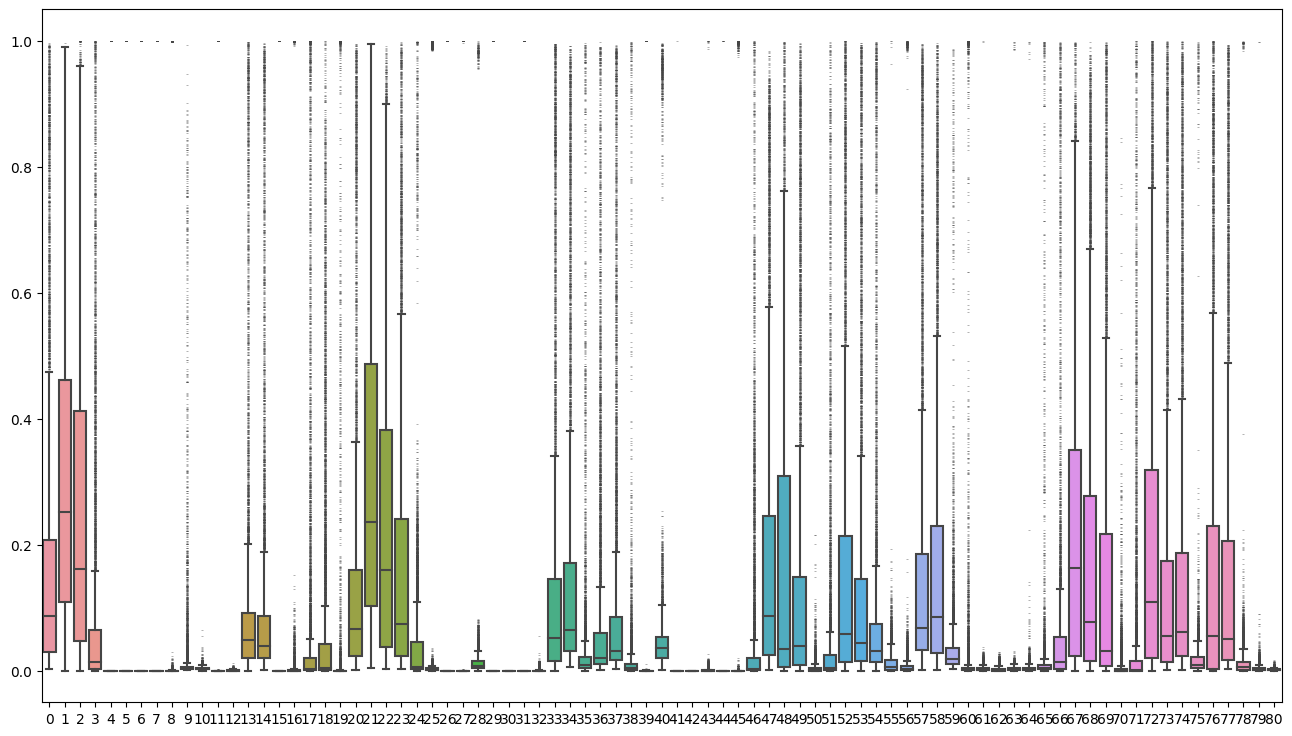

In [26]:
plt.figure(figsize = (16,9))
sns.boxplot(err_arr, fliersize = 0.1)
plt.show()

In [27]:
#Calculate MAPE:
pred_arr = np.load("./Saved_Models_Data/best_initial_enc_pred_orig.npy")
gt_arr = np.load("./Saved_Models_Data/best_initial_enc_GROUND_TRUTH.npy")
print(pred_arr.shape)
print(gt_arr.shape)

num_samples = 12433
vec_size = 81
err_arr = np.zeros((num_samples,vec_size))

#Manual calculation:
def mean_abs_perc_err(true, pred, num_samples, vec_size):
  print("Calculating MAPE")
  for r in range(len(pred_arr)):
    for c in range(vec_size):
      err_arr[r][c] = abs(gt_arr[r][c]-pred_arr[r][c]) # Calculation of the percentage error
  per_sample_mape_arr = np.sum(err_arr,axis=1)/vec_size
  print(per_sample_mape_arr.shape)
  print("MAPE for 10 samples...",per_sample_mape_arr[:10])
  overall_MAPE = sum(per_sample_mape_arr)/num_samples
  print("OVERALL MAPE: ", overall_MAPE)

mean_abs_perc_err(gt_arr, pred_arr, num_samples, vec_size)

(12433, 81)
(12433, 81)
Calculating MAPE
(12433,)
MAPE for 10 samples... [0.06045485 0.04664198 0.04883965 0.10192553 0.10564134 0.05394062
 0.12155448 0.15335758 0.08863754 0.05809474]
OVERALL MAPE:  0.07854707918379333


In [30]:
#Calculate R2 where I use SKLEARN, but go through each row:
from sklearn.metrics import r2_score
y_pred = np.load("./Saved_Models_Data/best_initial_enc_pred_orig.npy")
y_true = np.load("./Saved_Models_Data/best_initial_enc_GROUND_TRUTH.npy")

result_r2 = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the R-squared value for each row
    r2 = r2_score(y_true[i, :], y_pred[i, :])
    result_r2[i] = r2

print("R-squared value for each row (sample):", result_r2)
# Calculate the overall R-squared value
overall_r2 = np.mean(result_r2)

# Print the overall R-squared value
print("Overall R-squared value:", overall_r2)

R-squared value for each row (sample): [0.73450682 0.89559793 0.89648179 ... 0.82361288 0.70831119 0.77232811]
Overall R-squared value: 0.6807273685087645


In [31]:
#Spearman Correlation:
result = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Spearman correlation for each row
    row_result = scipy.stats.spearmanr(y_true[i, :], y_pred[i, :])

    # Checking for zero standard deviation
    if np.isnan(row_result.correlation) or np.isnan(row_result.pvalue):
        # Handle the case where the result contains NaN
        result[i] = 0  # Set the correlation coefficient to 0
    else:
        result[i] = row_result.correlation

print("Spearman correlation coefficients for each row (sample):", result)
overall_spearman_corr = np.mean(result)

# Print the overall Spearman correlation coefficient
print("Overall Spearman correlation coefficient:", overall_spearman_corr)

Spearman correlation coefficients for each row (sample): [0.57670705 0.61535237 0.61386601 ... 0.60940693 0.51725271 0.6034615 ]
Overall Spearman correlation coefficient: 0.5616795644945533


In [32]:
#Pearson Correlation:
result_pearson = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Pearson correlation for each row
    corr_matrix = np.corrcoef(y_true[i, :], y_pred[i, :])
    result_pearson[i] = corr_matrix[0, 1]

# Calculate the overall Pearson correlation coefficient
overall_pearson_corr = np.mean(result_pearson)

print("Pearson correlation coefficients for each row:", result_pearson)
print(len(result_pearson))
# Print the overall Pearson correlation coefficient
print("Overall Pearson correlation coefficient:", overall_pearson_corr)

Pearson correlation coefficients for each row: [0.85747562 0.94894798 0.95158062 ... 0.90899288 0.84169241 0.88191305]
12433
Overall Pearson correlation coefficient: 0.8231054696326366


In [35]:
#MCC: continuous y_pred values converted to BENESH 0.5 threshold:
from sklearn.metrics import matthews_corrcoef
y_pred = np.load("./Saved_Models_Data/best_initial_enc_pred_BENESH.npy")
y_true = np.load("./Saved_Models_Data/best_initial_enc_GROUND_TRUTH.npy")

result_mcc = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Matthews Correlation Coefficient for each row
    mcc = matthews_corrcoef(y_true[i, :], y_pred[i, :])
    result_mcc[i] = mcc

# Calculate the overall Matthews Correlation Coefficient
overall_mcc = np.mean(result_mcc)

# Print the overall Matthews Correlation Coefficient
print("Overall Matthews Correlation Coefficient:", overall_mcc)

Overall Matthews Correlation Coefficient: 0.7820058853087966
